In [1]:
# 경고(worning) 비표시
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 제3장 고객의 전체모습을 파악하는 테크닉 10

### 테크닉21 : 데이터를 읽어들이고 확인하자

- 데이터 설명

  - use_log.csv : 센터의 이용 이력 데이터 (2018년 4월 ~ 2019년 3월)

    use_log는 어떤 고객이 언제 센터를 이용했는지 알 수 있는 데이터

  - customer_master.csv : 2019년 3월 말  시점의 회원 데이터

    이름은 마스킹돼 있어서 이름만으로는 개인을 특정할 수 없음

    is_delete는 탈퇴한 유저를 빨리 찾기 위한 열
   
  - class_master.csv : 회원 구분 데이터(종일, 주간, 야간)
  
  - campaign_master.csv : 행사 구분 데이터 (입회비 유무 등)


In [3]:
import pandas as pd
uselog = pd.read_csv('/content/gdrive/MyDrive/pyda100-master/3장/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [4]:
customer = pd.read_csv('/content/gdrive/MyDrive/pyda100-master/3장/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [5]:
class_master = pd.read_csv('/content/gdrive/MyDrive/pyda100-master/3장/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [6]:
campaign_master = pd.read_csv('/content/gdrive/MyDrive/pyda100-master/3장/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


### 테크닉22 : 고객 데이터를 가공하자

- customer, class_master, campaign_master left join 진행

  회원 구분과 금액을 알 수 있게 데이터가 가공됨

In [7]:
customer_join = pd.merge(customer, class_master, on="class", how="left")
customer_join = pd.merge(customer_join, campaign_master, on="campaign_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [8]:
print(len(customer))
print(len(customer_join))

4192
4192


- 조인을 할 땐 키가 없거나 조인이 잘못되면 자동으로 결측치가 채워짐
  
  따라서 조인 후에는 결측치 확인이 필요

  end_date에 결측치가 있는 이유는 탈퇴하지 않은 회원의 탈퇴일이 공백이기 때문

In [9]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

### 테크닉23 : 고객데이터를 집계 해보자

- 집계 항목

    - 어떤 회원과 어떤 캠페인이 많은지

    - 언제 입회/탈퇴가 많은지

    - 남녀 비율은 얼마인지

    - 탈퇴할 때까지의 기간은 어느 정도 인지

In [10]:
customer_join.groupby("class_name").count()["customer_id"]

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

회원 크래스의 종일반이 거의 절반을 차치

In [11]:
customer_join.groupby("campaign_name").count()["customer_id"]

campaign_name
0_입회비반액할인     650
1_입회비무료       492
2_일반         3050
Name: customer_id, dtype: int64

캠페인은 일반 입회가 많음 

In [12]:
customer_join.groupby("gender").count()["customer_id"]

gender
F    1983
M    2209
Name: customer_id, dtype: int64

남녀 비율은 남자가 조금 더 많음

In [13]:
customer_join.groupby("is_deleted").count()["customer_id"]

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

2019년 3월 현재 가입된 회원은 2842명이고 탈퇴한 유저는 1350명임

In [14]:
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join.loc[customer_join["start_date"]>pd.to_datetime("20180401")]
print(len(customer_start))

1361


In [15]:
customer_start

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
2831,HI195873,XXX,C01,F,2018-04-02,2018-08-31 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2832,TS322485,XX,C03,F,2018-04-02,2018-08-31 00:00:00,CA3,1,2_야간,6000,1_입회비무료
2833,IK552971,XXXXX,C02,F,2018-04-02,2018-08-31 00:00:00,CA3,1,1_주간,7500,1_입회비무료
2834,PL000560,XXX,C01,M,2018-04-02,2018-07-31 00:00:00,CA3,1,0_종일,10500,1_입회비무료
2835,HD218970,XXXXX,C01,F,2018-04-02,2018-11-30 00:00:00,CA3,1,0_종일,10500,1_입회비무료
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반
4188,HD246549,XXXXX,C01,F,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반
4189,GD037007,XXXXX,C03,M,2019-03-14,NaN,CA1,0,2_야간,6000,2_일반
4190,OA953150,XXXXX,C01,M,2019-03-14,NaN,CA1,0,0_종일,10500,2_일반


start_date를  datetime형으로 변환 후, customer_Start변수에 해당 유저의 데이터를 저장하고 개수를 세어봄

이 기간 동안의 가입 인원이 1361명인 것을 알 수 있음

### 테크닉24 : 최근 고객데이터를 집계해보자

현재 고객 데이터에는 아마 탈퇴한 고객도 포함되어 있기 때문에 월별 집계와는 차이가 있음

최근 월(2019년 3월)을 추출하기 위해서 2019년 3월에 탈퇴한 고객과 재적 중인 고객을 추출하거나 is_delete 열로 추출하는 방법이 있음 

하지만 is_delete열로 추출하는 경우 탈퇴한 고객은 카운트되지 않기에 주의가 필요

is_delete를 사용하지 않는 방법으로 추출을 진행

In [23]:
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
customer_newer = customer_join.loc[(customer_join["end_date"]==pd.to_datetime("20190331"))|(customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

NaT는 탈퇴하지 않은 고객을 의미

In [24]:
customer_newer

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반
...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반
4188,HD246549,XXXXX,C01,F,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반
4189,GD037007,XXXXX,C03,M,2019-03-14,NaT,CA1,0,2_야간,6000,2_일반
4190,OA953150,XXXXX,C01,M,2019-03-14,NaT,CA1,0,0_종일,10500,2_일반


In [25]:
customer_newer.groupby("class_name").count()["customer_id"]

class_name
0_종일    1444
1_주간     696
2_야간     813
Name: customer_id, dtype: int64

In [26]:
customer_newer.groupby("campaign_name").count()["customer_id"]

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [27]:
customer_newer.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

전체를 집계했을 때와 큰 차이는 없지만 캠페인 구분에서는 약간 차이가 있음

전체로 했을 땐 일반으로 입회한 유저가 72%의 비율이였지만 그것에 반해 최근은 81%로 늘어났음

입회 캠페인은 회원 비율 변화에 영향을 미친다고 추측이 가능

### 테크닉25 : 이용이력 데이터를 집계하자

- 이용 이력 데이터는 시간적인 요소로 분석이 가능함
  - 한 달 이용 횟수의 변화
  - 회원이 스포츠 센터를 정기적으로 이용하는지 비정기적으로 이용하는지


In [41]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["연월","customer_id"],as_index=False).count()
# log_id 를 카운트
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
# usedate  삭제
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


AS002855 고객은 2018년 4월에 4번 이용했음을 알 수 있음

- 고객별로 평균값, 중앙값, 최댓값, 최솟값 집계

In [42]:
uselog_customer = uselog_months.groupby("customer_id").agg(["mean", "median", "max", "min" ])["count"]
# group by로 인해 customer id가 index에 있으므로 그것을 칼럼으로 변경
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


AS002855 고객의 월 이용 횟수를 알 수 있음

### 테크닉26 : 이용이력 데이터로부터 정기이용 여부  플래그를 작성하자

- 정기 이용 정의
  - 매주 같은 요일에 왔는지 아닌지로 정의

In [50]:
# 요일을 숫자로 변환 (0:월 ~ 6:일)
uselog["weekday"] = uselog["usedate"].dt.weekday
# 고객 연월 요일별로 log_id 를 카운트
uselog_weekday = uselog.groupby(["customer_id","연월","weekday"], 
                                as_index=False).count()[["customer_id","연월", "weekday","log_id"]]
uselog_weekday.rename(columns={"log_id":"count"}, inplace=True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


AS002855 고객은 결과를 보면 매주 토요일은 체육관을 방문하는 것으로 알 수 있음

 - 고객별 최댓값을 계산하고 4이상인 값의 경우 플래스를 지정

In [63]:
# 고객 단위로 집계하고 최댓값을 구함 즉, 특정 월, 특정 요일에 가장 많이 이용한 횟수
uselog_weekday = uselog_weekday.groupby("customer_id",as_index=False).max()[["customer_id", "count"]]
# routine_flg에 0을 입력하고, 3행에서는 횟수가 4 미만인 경우 원래의 값인 0을 그대로 두고 아닌 경우 1을 대입
uselog_weekday["routine_flg"] = 0
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"]<4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


이 횟수가 4 또는 5인 사람은 적어도 어떤 달의 매주 특정 요일에 정지적으로 방문한 고객

### 테크닉27 : 고객 데이터와 이용이력데이터를 결합하자

- 테크닉 25와 26에서 작성한 uselog_customer, use_weekday를 customer_join과 결합

In [64]:
customer_join = pd.merge(customer_join, uselog_customer, on="customer_id", how="left")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], on="customer_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean_x,median_x,max_x,min_x,calc_date,membership_period,mean_y,median_y,max_y,min_y,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,2019-04-30,47,4.833333,5.0,8,2,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,2019-04-30,47,5.083333,5.0,7,3,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,2019-04-30,47,4.583333,5.0,6,3,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,2019-04-30,47,4.833333,4.5,7,2,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,2019-04-30,47,3.916667,4.0,6,1,3.916667,4.0,6,1,1


In [65]:
customer_join.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean_x                  0
median_x                0
max_x                   0
min_x                   0
calc_date               0
membership_period       0
mean_y                  0
median_y                0
max_y                   0
min_y                   0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
dtype: int64

end_date 이외에는 결측치가 없는 것을 보아 결합에 문제가 없음

### 테크닉28 : 회원기간을 계산하자

회원기간은 start_date와 end_date의 차이

하지만 end_date에는 탈퇴하지 않은 회원은 결측치가 채워져 있기 때문에 그 회원들은 4월 30일로 채워서 회원 기간을 계산

3월 31일로 할 경우 실제로 3월 31일에 탈퇴한 사람들과 구별할 수 없기 때문

In [66]:
delta = relativedelta(customer_join["calc_date"].iloc[0], pd.to_datetime(customer_join["start_date"].iloc[0]))
print(delta)

relativedelta(years=+3, months=+11, days=+29)


In [67]:
print(delta.years*12)
print(delta.months)

36
11


In [68]:
from dateutil.relativedelta import relativedelta
customer_join["calc_date"] = customer_join["end_date"]
# 결측치에 20190430 대입
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
customer_join["membership_period"] = 0
for i in range(len(customer_join)):
    # relativedelta : 날짜 비교 함수
    delta = relativedelta(customer_join["calc_date"].iloc[i], pd.to_datetime(customer_join["start_date"].iloc[i]))
    # 회원 단위를 월 단위로 계산
    customer_join["membership_period"].iloc[i] = delta.years*12 + delta.months
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean_x,median_x,max_x,min_x,calc_date,membership_period,mean_y,median_y,max_y,min_y,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,2019-04-30,47,4.833333,5.0,8,2,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,2019-04-30,47,5.083333,5.0,7,3,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,2019-04-30,47,4.583333,5.0,6,3,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,2019-04-30,47,4.833333,4.5,7,2,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,2019-04-30,47,3.916667,4.0,6,1,3.916667,4.0,6,1,1


### 테크닉29 : 고객행동의 각종통계량을 파악하자

In [69]:
customer_join[["mean", "median", "max", "min"]].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


주의 ! 여기서 사용한 칼럼의 이름이 mean, median, max, min이라서 헷갈리기 쉬움 

고객의 매월 평균 이용 횟수의 평균, 최소, 최대 등을 나타낸 통계치



In [70]:
customer_join.groupby("routine_flg").count()["customer_id"]

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

1이 3413으로 정기적으로 이용하는 고객이 많다는 것을 알 수 있음

- 히스토그램을 작성

  - 분포는 숫자로 이해하기 어렵기 때문

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <a list of 10 Patch objects>)

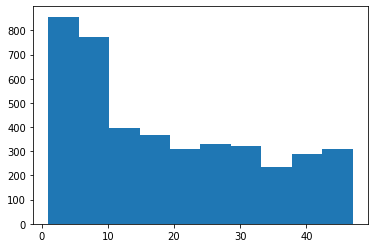

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

회원 기간이 10개월 이내인 고객이 많고, 10개월 이상의 고객의 수는 거의 일정한 것을 알 수 있음

이것으로 짧은 기간에 고객이 빠져나가는 업계라는 것을 시사함


### 테크닉30 : 탈퇴회원과 지속회원의 차이를 파악하자

- 탈퇴하는 고객의 특징을 알아보기 위해서 탈퇴 회원과 지속 회원을 나눠서 비교

In [72]:
customer_end = customer_join.loc[customer_join["is_deleted"]==1]
customer_end.describe()

,is_deleted,price,mean_x,median_x,max_x,min_x,membership_period,mean_y,median_y,max_y,min_y,mean,median,max,min,routine_flg
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,8.026667,3.865474,3.621852,6.461481,1.821481,3.865474,3.621852,6.461481,1.821481,0.456296
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,5.033692,1.246385,1.270847,2.584021,0.976361,1.246385,1.270847,2.584021,0.976361,0.498271
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,4.000000,3.000000,3.000000,4.000000,1.000000,3.000000,3.000000,4.000000,1.000000,0.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,7.000000,4.000000,4.000000,7.000000,2.000000,4.000000,4.000000,7.000000,2.000000,0.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,11.000000,4.666667,4.500000,8.000000,2.000000,4.666667,4.500000,8.000000,2.000000,1.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,23.000000,9.000000,9.000000,13.000000,8.000000,9.000000,9.000000,13.000000,8.000000,1.000000


In [73]:
customer_stay = customer_join.loc[customer_join["is_deleted"]==0]
customer_stay.describe()

,is_deleted,price,mean_x,median_x,max_x,min_x,membership_period,mean_y,median_y,max_y,min_y,mean,median,max,min,routine_flg
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,23.970443,6.030288,6.024279,8.471147,3.620690,6.030288,6.024279,8.471147,3.620690,0.984166
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,13.746761,1.553587,1.599765,1.571048,2.030488,1.553587,1.599765,1.571048,2.030488,0.124855
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,1.000000,3.166667,3.000000,5.000000,1.000000,3.166667,3.000000,5.000000,1.000000,0.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,12.000000,4.833333,5.000000,7.000000,2.000000,4.833333,5.000000,7.000000,2.000000,1.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,24.000000,5.583333,5.500000,8.000000,3.000000,5.583333,5.500000,8.000000,3.000000,1.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,35.000000,7.178030,7.000000,10.000000,5.000000,7.178030,7.000000,10.000000,5.000000,1.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,47.000000,12.000000,12.000000,14.000000,12.000000,12.000000,12.000000,14.000000,12.000000,1.000000


매월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값은 모두 지속 회원보다 작음

매월 최대 이용 횟수의 평균값은 지속 회원이 높긴 하지만 탈퇴 회원도 6.4정도

routine_flg는 지속 회원은 0.98로 많은 회원이 정기적으로 이용 하지만 탈퇴 회원은 0.45로 절반은 랜덤하게 이용하고 있음

In [75]:
customer_join.to_csv("/content/gdrive/MyDrive/pyda100-master/3장/customer_join.csv", index=False)